In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue May 23 21:31:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sklearn
import numpy as np
from glob import glob
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline

import string
from os import listdir
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from pickle import dump
from string import punctuation

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#load data
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance.csv', encoding='UTF-8')
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance_upload.csv')
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance_upload_with_augment.csv')
df = pd.read_csv('/content/drive/MyDrive/Dataset/last_dataset.csv')
#reset index
#df.set_index('id', inplace = True)
df.head()

,comment_text,toxic,threat,obscene,religious
0,"অয় ভাই,লজ্জাবতী লতা_____ হেতেরে গে দিয়া চুম্মা।",1,0,1,0
1,"অসভ্য,",1,0,0,0
2,অসুবিধা নাই। নিজেরা দুর্নিতি করে সহযোগিদের ফা...,1,0,1,0
3,"অারিপ্পার পুটকিতে বাল গজুক অার নাই গজুক, অাজ ...",1,0,1,0
4,আইভি সাথে নির্বাচন করতে হলে খালেদা জিয়া লাগবে...,1,0,1,0


In [ ]:
filter = df["comment_text"] != ""
df = df[filter]
df = df.dropna()

In [ ]:
#df = df.drop(['Toxic', 'NonToxic'], axis=1 )
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,comment_text,toxic,threat,obscene,religious
0,রোজা রমজানে এইসব বেহায়া অসভ্য নাস্তিক মেয়ে টার...,0,0,0,1
1,চাটা গোলাম,0,0,1,0
2,সেই যদি পরকাল কে বিশ্বাস নাই করে তাহলে নিজেকে ...,0,0,0,1
3,সালা হলে জাবে মসজিদ বন্ধ করা হলে তোর কপালে জুত...,0,0,0,1
4,এ খান্কি মাগির পাথর মেরে দুনিয়া থেকে বিদায় কর,1,0,1,0


In [ ]:
df = df.loc[((df['toxic'] == 1) | (df['threat'] == 1) | (df['obscene'] ==1) | (df['religious'] == 1))]

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,comment_text,toxic,threat,obscene,religious
0,খাংকির পোলা তোর থোত্মায় এই কথা মানায় না,1,0,1,0
1,এই পত্রিকা টা এইসব নাস্তিক ফাসতিক দের খুব prom...,0,0,0,1
2,খুব পছন্দের মডেল ছিলে। কিন্তু মিয়া খলিফার থেক...,0,0,0,1
3,মেখে সুন্দর,1,0,1,0
4,দুধ চুষে,1,0,1,0


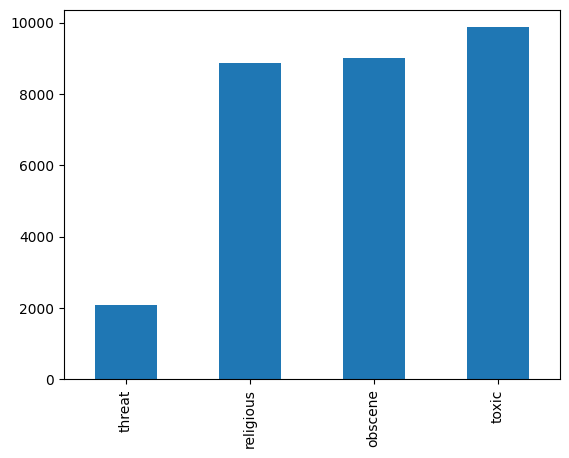

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="bar");

In [ ]:
df[LABEL_COLUMNS].sum()

toxic        9870
threat       2100
obscene      9013
religious    8880
dtype: int64

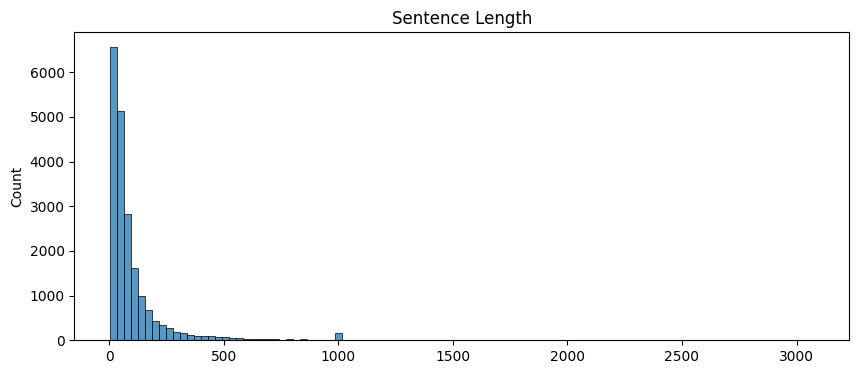

In [ ]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 4))
sns.histplot([len(s) for s in df.comment_text], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
stop_word_list = (stopwords.words('bengali'))

In [ ]:
import string

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()

	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]

	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if not word.isalpha()]

	# filter out stop words
	stop_words = stop_word_list
	tokens = [w for w in tokens if not w in stop_words]

	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	tokens = ' '.join(tokens)
	return tokens

In [ ]:
df['comment_text'] = df.comment_text.apply(clean_doc)

In [ ]:
sample_row = df.iloc[125]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print(sample_labels.to_dict())

তোর মুখটা কুকুরের পুটকির মতো। সালা হিজরা
{'toxic': 1, 'threat': 0, 'obscene': 1, 'religious': 1}


**Train Test Split**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
!pip3 install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X = df['comment_text']

In [ ]:
X

0                        খাংকির পোলা তোর থোত্মায় কথা মানায়
1                            পত্রিকা টা নাস্তিক ফাসতিক দের
2        পছন্দের মডেল ছিলে। মিয়া খলিফার বাজে করেছো পরকা...
3                                              মেখে সুন্দর
4                                                 দুধ চুষে
                               ...                        
20279                       তোমাকে জুতার ধোলাই জারজ সন্তান
20280                                   টা ওষুধ খেলে সেক্স
20281    মানুষের ব্যবহারের সাথে চেহারার অনেকটা মিল থাকে...
20282                                      বুঝবে বুঝবে কাল
20283           কোথাও ভালো হাত পা বেধে সবাই মিলে একটা উচিৎ
Name: comment_text, Length: 20284, dtype: object

In [ ]:
y = df[['toxic', 'threat', 'obscene', 'religious']]
y

,toxic,threat,obscene,religious
0,1,0,1,0
1,0,0,0,1
2,0,0,0,1
3,1,0,1,0
4,1,0,1,0
...,...,...,...,...
20279,0,1,0,0
20280,1,0,1,0
20281,0,1,0,0
20282,0,1,0,0


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 11.6 MB/s eta 0:00:00


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
X

array(['খাংকির পোলা তোর থোত্মায় কথা মানায়',
       'পত্রিকা টা নাস্তিক ফাসতিক দের',
       'পছন্দের মডেল ছিলে। মিয়া খলিফার বাজে করেছো পরকাল বিশ্বাস করনা মানে নাস্তিক। ছি ছি ছি সাফা। ভাবের ঠেলাই পাপ টা একটু বেশিই ফেলতাছো। দিস ফেয়ার',
       ...,
       'মানুষের ব্যবহারের সাথে চেহারার অনেকটা মিল থাকে। পাল্টানোর সাথে সাথে চেহারাও পাল্টে।সে বাড়িতেপুরনো একটা পুড়িয়েছিলেন কারনে।উনার প্রতিবেশী হিন্দুরাই উনার ভাইয়ের অত্যাচারে অতিষ্ঠ।কারন স্বামী দুদকের পরিচালক।তাকে জাতীয় বেইমান উপাধী দেয়া অস্বাবিক না। ছিড়া জুতা নির্মিত মালা দিয়েমিথ্যার অস্কার দেয়া',
       'বুঝবে বুঝবে কাল', 'কোথাও ভালো হাত পা বেধে সবাই মিলে একটা উচিৎ'],
      dtype=object)

In [ ]:
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.40, random_state=42)
for train_index, test_index in msss.split(X, y):
        x_train, x_test_temp = X[train_index], X[test_index]
        y_train, y_test_temp = y[train_index], y[test_index]

In [ ]:
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=42)
for val_index, test_index in msss.split(x_test_temp, y_test_temp):
        x_val, x_test = X[val_index], X[test_index]
        y_val, y_test = y[val_index], y[test_index]

In [ ]:
len(x_train), len(x_val), len(x_test)

(12146, 4880, 3258)

**BERT WORD EMBEDDING**

In [ ]:
%%capture
!pip3 install transformers
#!pip install transformers

In [ ]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import BertTokenizer, TFBertModel

In [ ]:
# hyperparameters
max_length = 300
batch_size = 16
dev_size = 0.2

In [ ]:
import tensorflow as tf

In [ ]:
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

In [ ]:
X_input_ids_train = np.zeros((len(x_train), max_length))
X_attn_masks_train = np.zeros((len(x_train), max_length))

X_input_ids_dev = np.zeros((len(x_val), max_length))
X_attn_masks_dev = np.zeros((len(x_val), max_length))

X_input_ids_test = np.zeros((len(x_test), max_length))
X_attn_masks_test = np.zeros((len(x_test), max_length))

In [ ]:
from tqdm import tqdm
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids_tain, X_attn_masks_tain = preprocessing_dataset(x_train, X_input_ids_train, X_attn_masks_train, tokenizer)
X_input_ids_dev, X_attn_masks_dev = preprocessing_dataset(x_val, X_input_ids_dev, X_attn_masks_dev, tokenizer)
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(x_test, X_input_ids_test, X_attn_masks_test, tokenizer)

12146it [00:18, 645.36it/s]
4880it [00:09, 524.23it/s]
3258it [00:03, 941.59it/s]


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_tain, X_attn_masks_tain, y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_dev, X_attn_masks_dev, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, y_test))

In [ ]:
def VulgarDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
train_dataset = train_dataset.map(VulgarDatasetMapFunction)
dev_dataset = dev_dataset.map(VulgarDatasetMapFunction)
test_dataset = test_dataset.map(VulgarDatasetMapFunction)

In [ ]:
train_dataset = train_dataset.shuffle(100).batch(batch_size)
dev_dataset = dev_dataset.shuffle(100).batch(batch_size)
test_dataset = test_dataset.shuffle(100).batch(batch_size)


In [ ]:
from tensorflow import keras

In [ ]:
from keras.optimizers import Adam

In [ ]:
# from keras.optimizers import adam_v2
# '''from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D, Dropout
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# from tensorflow.keras.models import Sequential'''


In [ ]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import CuDNNLSTM

In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import LSTM
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate
from pickle import load

from keras.layers import Conv1D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed

In [ ]:
#Import necessary libraries
# demonstration of calculating metrics for a neural network model using sklearn
import keras.backend as K
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.metrics import Metric


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

In [ ]:
from keras import initializers as initializers, regularizers, constraints
REG_PARAM = 1e-13
#l2_reg = regularizers.l2(REG_PARAM)

In [ ]:
# def bert_model():
#     bert_encoder = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
#     input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
#     attn_masks = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

#     encoder_embedding_layer = bert_encoder(input_word_ids, attention_mask=attn_masks)[0]

#     conv1 = Conv1D(filters=32, kernel_size=4, activation='leaky_relu')(encoder_embedding_layer)
#     drop1 = Dropout(0.3)(conv1)
#     pool1 = MaxPooling1D(pool_size=2)(drop1)
#     flat1 = Flatten()(pool1)

#     # channel 2
#     #input2 = Input(shape=(length,))
#     #embedding_layer_2 = embedding_layer(input2)
#     conv2 = Conv1D(filters=32, kernel_size=6, activation='leaky_relu')(encoder_embedding_layer)
#     drop2 = Dropout(0.3)(conv2)
#     pool2 = MaxPooling1D(pool_size=2)(drop2)
#     flat2 = Flatten()(pool2)

#     # channel 3
#     #input3 = Input(shape=(length,))
#     #embedding_layer_3 = embedding_layer(input3)
#     conv3 = Conv1D(filters=32, kernel_size=8, activation='leaky_relu')(encoder_embedding_layer)
#     drop3 = Dropout(0.3)(conv3)
#     pool3 = MaxPooling1D(pool_size=2)(drop3)
#     flat3 = Flatten()(pool3)

#     # merge
#     CNN_layer = concatenate([flat1, flat2, flat3])

#     # LSTM
#     #x = embedding_layer(input3)
#     LSTM_layer = LSTM(128, kernel_regularizer=regularizers.l2(1e-12))(encoder_embedding_layer)

#     CNN_LSTM_layer = concatenate([LSTM_layer, CNN_layer])
#     CNN_LSTM_layer = tf.keras.layers.Dropout(0.3)(CNN_LSTM_layer)
#     # interpretation
#     dense1 = Dense(80, activation='leaky_relu')(CNN_LSTM_layer)
#     output = Dense(4, activation='sigmoid')(dense1)

#     # Finally building model
#     model = keras.Model(inputs=[input_word_ids, attn_masks], outputs=output)


#     return model

In [ ]:
def bert_model():
    bert_encoder = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attn_masks = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    encoder_embedding_layer = bert_encoder(input_word_ids, attention_mask=attn_masks)[0]

    conv1 = Conv1D(filters=32, kernel_size=4, activation='leaky_relu')(encoder_embedding_layer)
    drop1 = Dropout(0.3)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)

    conv2 = Conv1D(filters=32, kernel_size=6, activation='leaky_relu')(pool1)
    drop2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)

    conv3 = Conv1D(filters=32, kernel_size=8, activation='leaky_relu')(pool2)
    drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)

    CNN_layer = Flatten()(pool3)

    # BiLSTM
    LSTM_layer = Bidirectional(LSTM(128, kernel_regularizer=regularizers.l2(1e-13)))(encoder_embedding_layer)

    CNN_BiLSTM_layer = concatenate([LSTM_layer, CNN_layer])
    CNN_BiLSTM_layer = Dropout(0.3)(CNN_BiLSTM_layer)

    dense1 = Dense(80, activation='leaky_relu')(CNN_BiLSTM_layer)
    output = Dense(4, activation='sigmoid')(dense1)

    model = keras.Model(inputs=[input_word_ids, attn_masks], outputs=output)

    return model


In [ ]:
model = bert_model()

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy', fmeasure, precision, recall])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  164396544   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

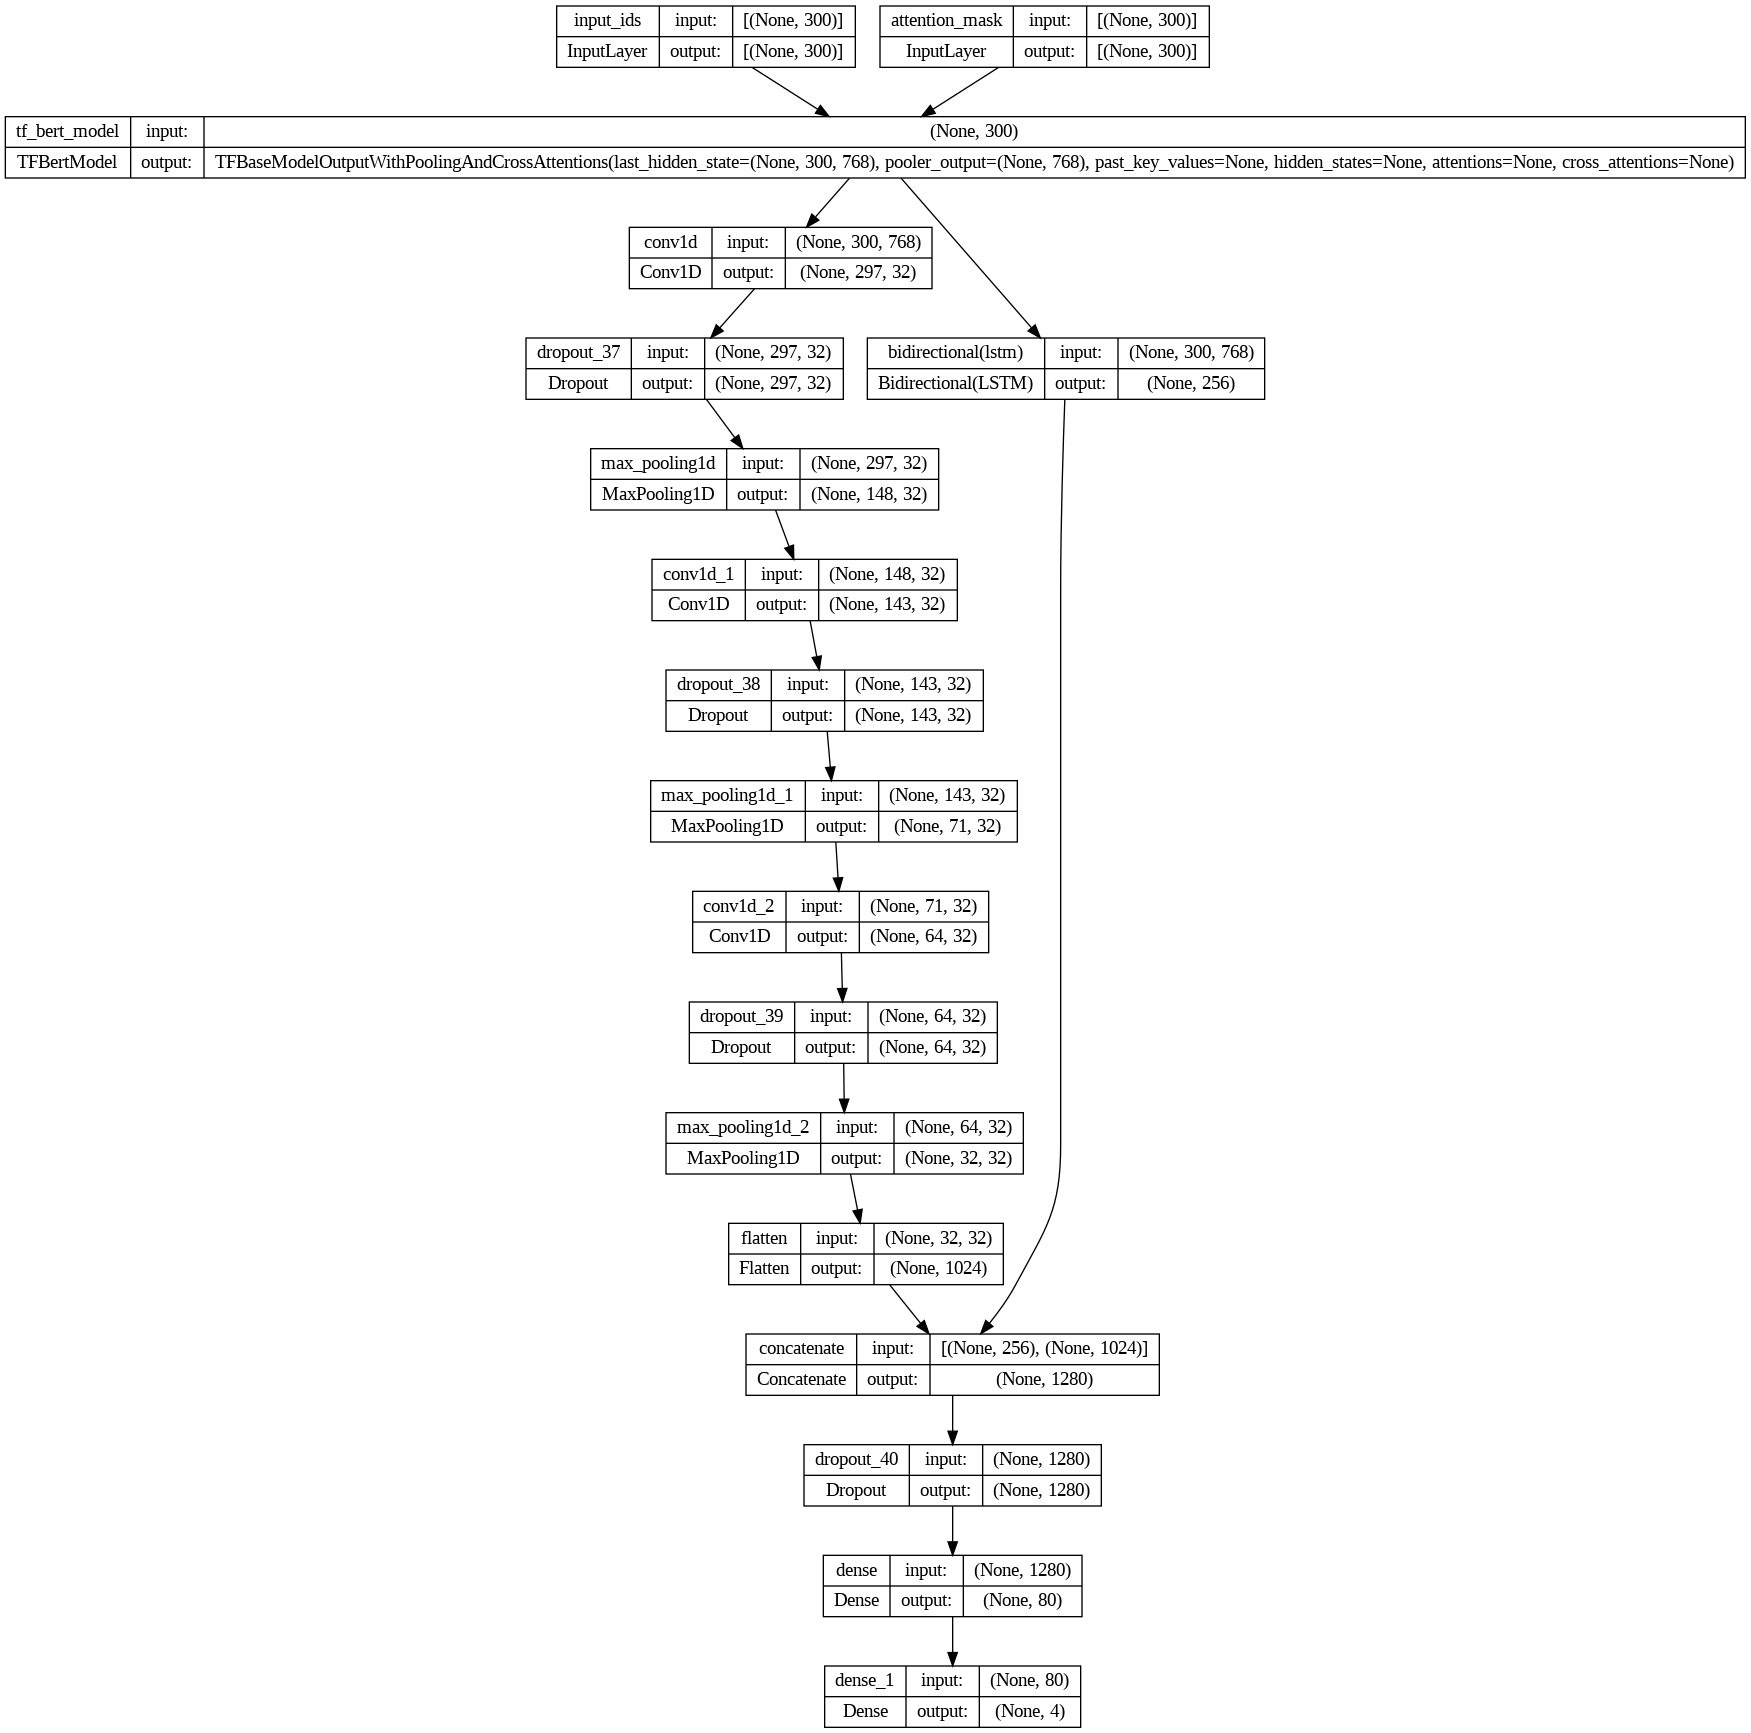

In [ ]:
#plot the vulgar detection model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='toxic_detection_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='toxic_detection_model_plot.png')

In [ ]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
history = model.fit(
    train_dataset,
    batch_size=256,
    epochs=8,
    validation_data=dev_dataset,
    validation_steps=20,
    verbose=1)

Epoch 1/8
760/760 [==============================] - 901s 1s/step - loss: 0.3894 - accuracy: 0.6534 - fmeasure: 0.7693 - precision: 0.7730 - recall: 0.7713 - val_loss: 0.2866 - val_accuracy: 0.7844 - val_fmeasure: 0.8504 - val_precision: 0.8415 - val_recall: 0.8612
Epoch 2/8
760/760 [==============================] - 816s 1s/step - loss: 0.2556 - accuracy: 0.7323 - fmeasure: 0.8678 - precision: 0.8703 - recall: 0.8686 - val_loss: 0.2346 - val_accuracy: 0.8313 - val_fmeasure: 0.8797 - val_precision: 0.8714 - val_recall: 0.8892
Epoch 3/8
760/760 [==============================] - 812s 1s/step - loss: 0.2027 - accuracy: 0.7809 - fmeasure: 0.8955 - precision: 0.8960 - recall: 0.8975 - val_loss: 0.1913 - val_accuracy: 0.8344 - val_fmeasure: 0.9000 - val_precision: 0.8873 - val_recall: 0.9140
Epoch 4/8
760/760 [==============================] - 817s 1s/step - loss: 0.1604 - accuracy: 0.8160 - fmeasure: 0.9183 - precision: 0.9171 - recall: 0.9218 - val_loss: 0.1714 - val_accuracy: 0.8719 - va

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Shafa/MConv_LSTM_BERT")

In [ ]:
test_score = model.evaluate(test_dataset)

print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

204/204 [==============================] - 76s 371ms/step - loss: 0.1543 - accuracy: 0.8907 - fmeasure: 0.9323 - precision: 0.9222 - recall: 0.9441
Test Loss: 0.1542825847864151
Test Accuracy: 0.8907305002212524


In [ ]:
y_pred = model.predict([X_input_ids_test, X_attn_masks_test])

102/102 [==============================] - 74s 689ms/step


In [ ]:
len(y_test), len(y_pred)

(3258, 3258)

In [ ]:
Threshold = 0.5
upper, lower = 1, 0

In [ ]:
from sklearn.metrics import classification_report
y_pred1 = y_pred
y_true = y_test



y_pred1 = np.where(y_pred >= .5, upper, lower)

print(classification_report(
  y_true,
  y_pred1,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

              precision    recall  f1-score   support

       toxic       0.92      0.96      0.94      1548
      threat       0.90      0.83      0.86       340
     obscene       0.88      0.96      0.92      1375
   religious       0.97      0.94      0.95      1483

   micro avg       0.92      0.94      0.93      4746
   macro avg       0.92      0.92      0.92      4746
weighted avg       0.92      0.94      0.93      4746
 samples avg       0.93      0.94      0.93      4746



In [ ]:
#https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation/notebook

from sklearn.metrics import multilabel_confusion_matrix
conf_mat = multilabel_confusion_matrix(y_test, y_pred1)

In [ ]:
def multilabel_accuracies(p):
    TP = p[1][1]
    TN = p[0][0]
    FP = p[0][1]
    FN = p[1][0]
    acc = (TP + TN) / (TP + TN + FP + FN)
    print(acc)

In [ ]:
print("Each label accuracy: ")
for i in range(len(conf_mat)):
    print(LABEL_COLUMNS[i])
    multilabel_accuracies(conf_mat[i])

Each label accuracy: 
toxic
0.941682013505218
threat
0.9720687538367097
obscene
0.9281767955801105
religious
0.9594843462246777


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.40561628974974157)

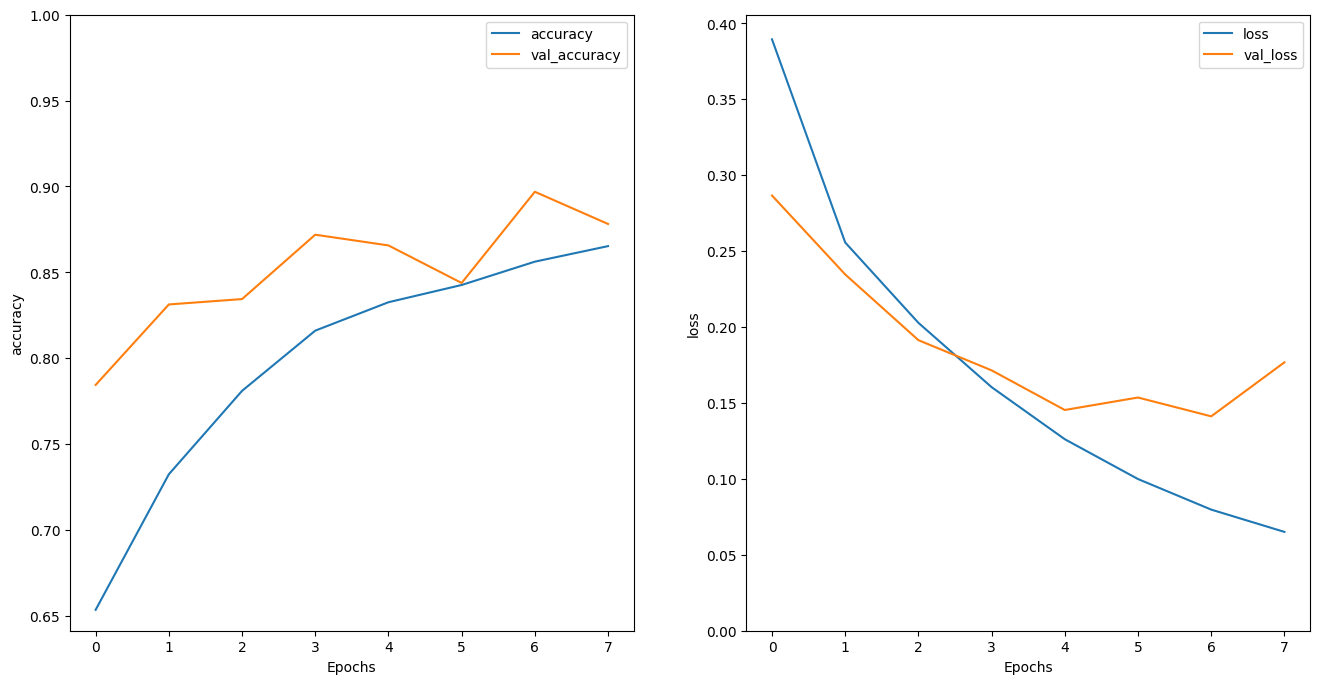

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
#model.save_weights("/content/drive/MyDrive/Colab Notebooks/Belal/CNN_LSTM_ATTENTION_BERT_WITH_ATTENTION")

In [ ]:
model1 = model

In [ ]:
model1.load_weights("/content/drive/MyDrive/Colab Notebooks/Shafa/MConv_LSTM_BERT")

In [ ]:
#sample_text = ['খানকির পুলা', 'মেরে সাফা করে ফেল', 'নাটকটা খুব সুন্দর আমার খুব ভাল লেগেছে']
#sample_text = bert_encode(['নাটকটা খুব সুন্দর আমার খুব ভাল লেগেছে'])


In [ ]:
LABEL_COLUMNS

['toxic', 'threat', 'obscene', 'religious']

Predicting New Sentence

In [ ]:
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=300,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=LABEL_COLUMNS):
    probs = model.predict(processed_data)[0]
    return np.where(probs >= Threshold, upper, lower)

input_text = clean_doc('খানকি মাগী বের হয়ে যা')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model, processed_data=processed_data)
print(f"Classification results: {result}")

1/1 [==============================] - 5s 5s/step
Classification results: [1 0 1 0]


In [ ]:
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=300,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=LABEL_COLUMNS):
    probs = model.predict(processed_data)[0]
    return np.where(probs >= Threshold, upper, lower)

input_text = clean_doc('বেয়াদবের বাচ্চা খালি বিয়ে করে বেড়ায়')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model, processed_data=processed_data)
print(f"Classification results: {result}")

1/1 [==============================] - 0s 111ms/step
Classification results: [1 0 1 0]


In [ ]:
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=300,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=LABEL_COLUMNS):
    probs = model.predict(processed_data)[0]
    return np.where(probs >= Threshold, upper, lower)

input_text = clean_doc('এক্কেবারে বাপের মত লুইচ্চা হইছে ছেলে')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model, processed_data=processed_data)
print(f"Classification results: {result}")

1/1 [==============================] - 0s 110ms/step
Classification results: [1 0 1 0]
